In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import tensorflow as tf

from collections import Counter
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\Ronnie\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
def adv_stock_indicators(df):
    df.reset_index()
    #Simple Moving Averages
    df['SMA12'] = df['Close'].rolling(12).mean()
    df['SMA26'] = df['Close'].rolling(26).mean()

    #Exponential Moving Averages
    df['EMA12'] = df['Close'].ewm(span=12).mean()
    df['EMA26'] = df['Close'].ewm(span=26).mean()

    #Using absolute as difference
    df['SMA12_pctchg'] = abs(((df['Close'] - df['SMA12']) / df['SMA12']) * 100) 
    df['SMA26_pctchg'] = abs(((df['Close'] - df['SMA26']) / df['SMA26']) * 100)
    df['EMA12_pctchg'] = abs(((df['Close'] - df['EMA12']) / df['EMA12']) * 100) 
    df['EMA26_pctchg'] = abs(((df['Close'] - df['EMA26']) / df['EMA26']) * 100) 

    #RSI using EMA
    #Default window length: 14
    delta = df['Close'].diff()
    window_length = 14

    up = delta.copy()
    up[delta<=0]=0.0
    down = abs(delta.copy())
    down [delta>0]=0.0

    RS_up = up.ewm(window_length).mean()
    RS_down = down.ewm(window_length).mean()

    rsi= 100-100/(1+RS_up/RS_down)
    df['RSI'] = rsi

    #MACD
    #Default: Fast Length=EMA12, Slow Length=EMA26, MACD Length=EMA9
    df['MACD'] = df['Close'].ewm(span=12).mean() - df['Adj Close'].ewm(span=26).mean()
    df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()

    #Percent Change
    df['Pct_Chg'] = df['Close'].pct_change() * 100
    
    #Bollinger Bands
    df['Upper_BB'] = df['Close'].rolling(window=20).mean() + (df['Close'].rolling(window=20).std() * 2)
    df['Upper_BB_pctchg'] = abs(((df['Close'] - df['Upper_BB']) / df['Upper_BB']) * 100)

    df['Lower_BB'] = df['Close'].rolling(window=20).mean() - (df['Close'].rolling(window=20).std() * 2)
    df['Lower_BB_pctchg'] = abs(((df['Close'] - df['Lower_BB']) / df['Lower_BB']) * 100)
    
    df['Range_BB'] = (df['Upper_BB'] - df['Lower_BB']) / df['Lower_BB'] * 100
    
    #Candlestick Range
    df['Candlestick_range'] = (df['High'] - df['Low']) / df['Low'] * 100
    
    #Dollar Volume
    df['Dollar_volume'] = df['Close'] * df['Volume']
    df['Rolling_Dollar_volume'] = df['Dollar_volume'].rolling(10).mean()

    df.dropna(inplace=True)

def classify_bullish(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0
    
def classify_bearish(current, future):
    if float(future) < float(current):
        return 1
    else:
        return 0

In [3]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras

In [4]:
svm_cv = pickle.load(open("models/svm_cv_best.pickle","rb"))
logreg_cv = pickle.load(open("models/logreg_cv_best.pickle","rb"))
rf_cv = pickle.load(open("models/rf_cv_best.pickle","rb"))
xgb_cv = pickle.load(open("models/xgb_cv_best.pickle","rb"))
ann = tf.keras.models.load_model('models/ann.h5')

In [7]:
def create_backtest_df(ticker):
    
    df = web.DataReader(ticker, 'yahoo', '2019-01-01', '2019-12-31')
    columns = ['Returns', 'Unemployment Rate', 'Inflation Rate', 'Misery Index',
       'local_price', 'Bullish', 'Neutral', 'Bearish', 'Bull-Bear Spread',
       'EMA12_pctchg', 'RSI', 'Pct_Chg', 'MACD_sentiment', 'Upper_BB_pctchg',
       'Lower_BB_pctchg', 'EMA_sentiment', 'Volume_sentiment']

    adv_stock_indicators(df)

    df['MACD_sentiment'] = list(map(classify_bullish, df['MACD'], df['MACD_Signal']))
    df['EMA_sentiment'] = list(map(classify_bullish, df['EMA26'], df['EMA12']))
    df['Volume_sentiment']  = list(map(classify_bullish, df['Dollar_volume'], df['Rolling_Dollar_volume']))
    
    alternative_data = pd.read_csv('data/cleaned_alternative_data.csv', index_col='index')
    alternative_data.drop('Unnamed: 0', axis=1, inplace=True)
    
    full_df = alternative_data.join(df).dropna()

    full_df['svm_buy_predictions'] = svm_cv.predict(full_df[columns])
    full_df['logreg_buy_predictions'] = logreg_cv.predict(full_df[columns])
    full_df['rf_buy_predictions'] = rf_cv.predict(full_df[columns])
    full_df['xgboost_buy_predictions'] = xgb_cv.predict(full_df[columns])
    full_df['ann_buy_predictions'] = np.argmax(ann.predict(full_df[columns]), axis=-1)
    
    full_df['buy_predictions'] = full_df[['svm_buy_predictions',
                                            'logreg_buy_predictions',
                                            'rf_buy_predictions', 
                                            'xgboost_buy_predictions',
                                            'ann_buy_predictions'
                                            ]].mode(axis=1)

    return full_df[['Adj Close', 'buy_predictions']]

def run_backtest(backtest_df, ticker):
    buy_hold = backtest_df['Adj Close'][-1] - backtest_df['Adj Close'][0]

    bulls = []

    for i, row in backtest_df.reset_index().iterrows():
        if row[2] == 1:
            try:
                bulls.append(backtest_df.iloc[i+5][0] - row[1])
            except:
                continue

    print("Ticker:", ticker)
    print("\tBull Profits", round(sum(bulls)*100),2)
    print("Baseline Buy & Hold Strategy:")
    print("\tTotal Profits: $", round(buy_hold*100, 2))
    
    plt.figure(figsize=(18,4))
    plt.subplot(1, 2, 1)
    plt.plot(backtest_df['Adj Close'])
    plt.title(f'{ticker} ' "Adj Close")
    plt.ylabel("Price (USD)")
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.plot(np.cumsum(bulls))
    plt.ylabel("Profits (USD) Per Share")
    plt.xlabel("Plays")
    plt.title(f'{ticker} ' "Bull Backtest")

    print("=====================================================")

Ticker: AAPL
	Bull Profits 37194.0 2
Baseline Buy & Hold Strategy:
	Total Profits: $ 12402.57
Ticker: NVDA
	Bull Profits 20890.0 2
Baseline Buy & Hold Strategy:
	Total Profits: $ 8128.54
Ticker: AMD
	Bull Profits 8788.0 2
Baseline Buy & Hold Strategy:
	Total Profits: $ 2273.0
Ticker: CRON
	Bull Profits -5710.0 2
Baseline Buy & Hold Strategy:
	Total Profits: $ -1315.0
Ticker: NFLX
	Bull Profits 3865.0 2
Baseline Buy & Hold Strategy:
	Total Profits: $ -3550.0
Ticker: TSLA
	Bull Profits 12479.0 2
Baseline Buy & Hold Strategy:
	Total Profits: $ 11456.0
Ticker: FB
	Bull Profits 15940.0 2
Baseline Buy & Hold Strategy:
	Total Profits: $ 4130.0


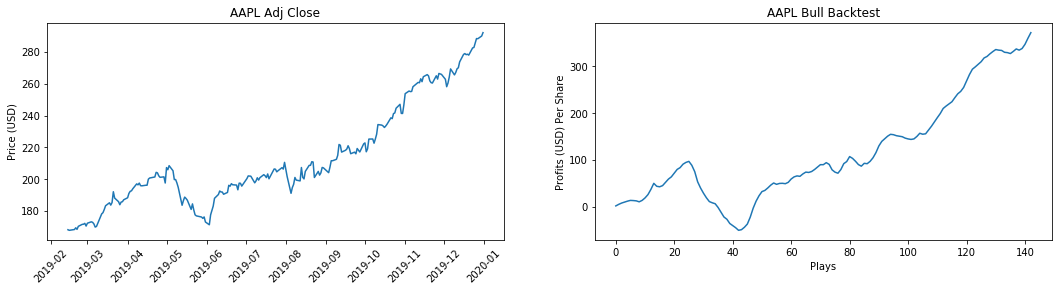

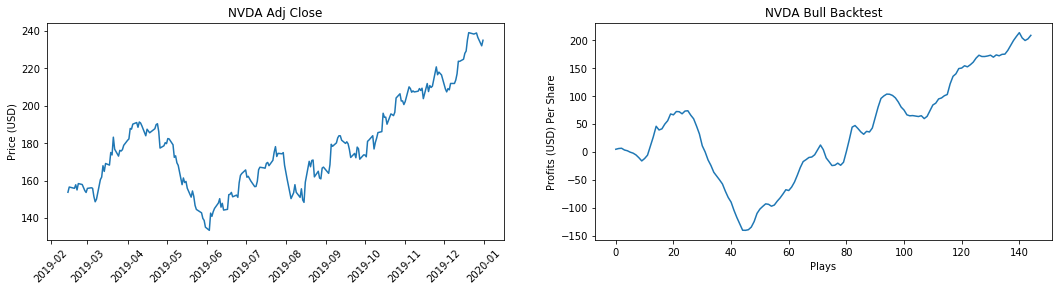

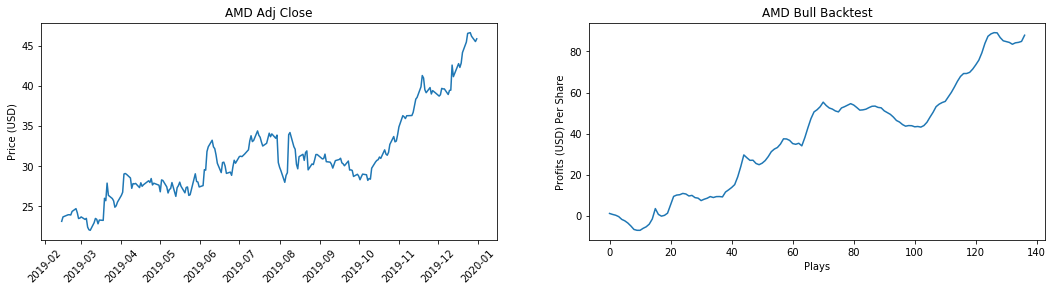

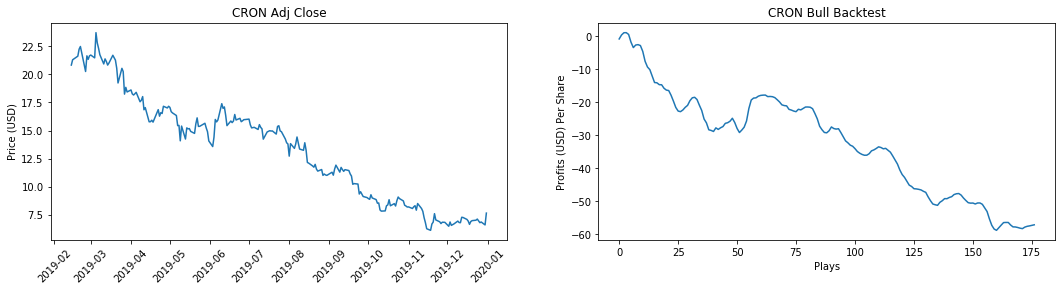

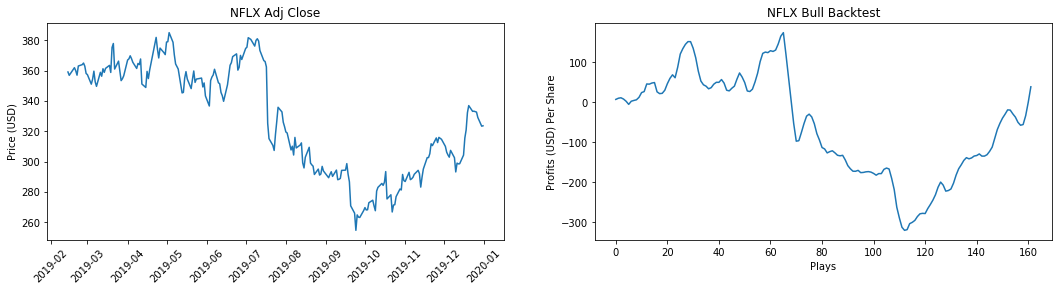

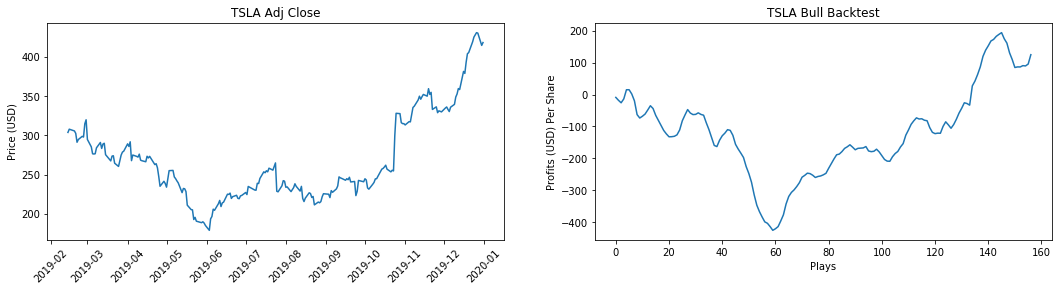

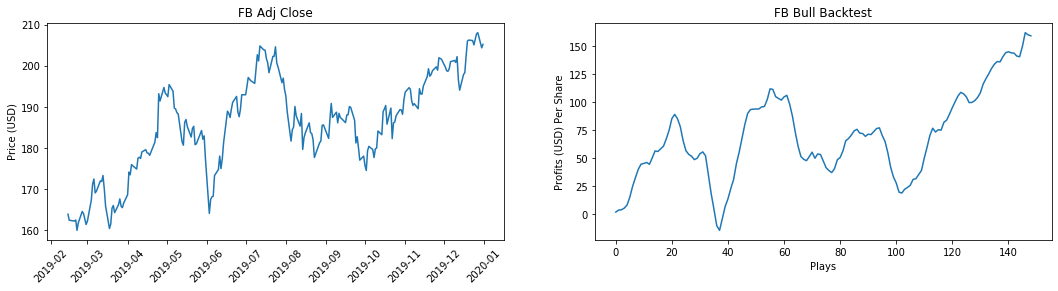

In [8]:
tickers = ['AAPL','NVDA','AMD','CRON','NFLX', 'TSLA', 'FB']
for ticker in tickers:
    backtest_df = create_backtest_df(ticker)
    run_backtest(backtest_df, ticker)

Ticker: AMZN
	Bull Profits 15278.0 2
Baseline Buy & Hold Strategy:
	Total Profits: $ 22518.99
Ticker: MA
	Bull Profits 23623.0 2
Baseline Buy & Hold Strategy:
	Total Profits: $ 7938.97
Ticker: V
	Bull Profits 16802.0 2
Baseline Buy & Hold Strategy:
	Total Profits: $ 4526.3
Ticker: PYPL
	Bull Profits 3247.0 2
Baseline Buy & Hold Strategy:
	Total Profits: $ 1375.0


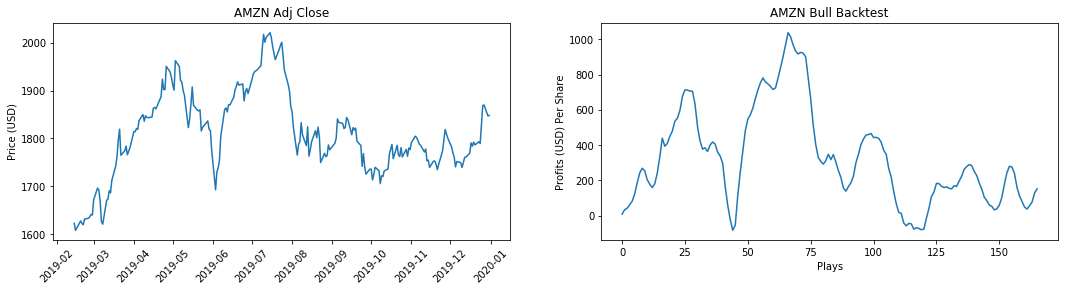

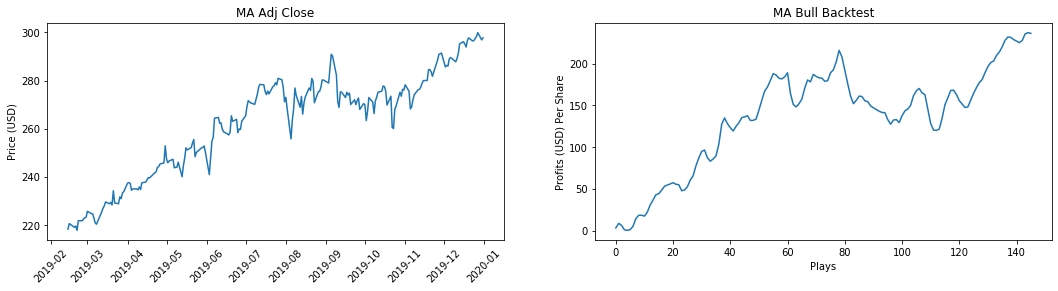

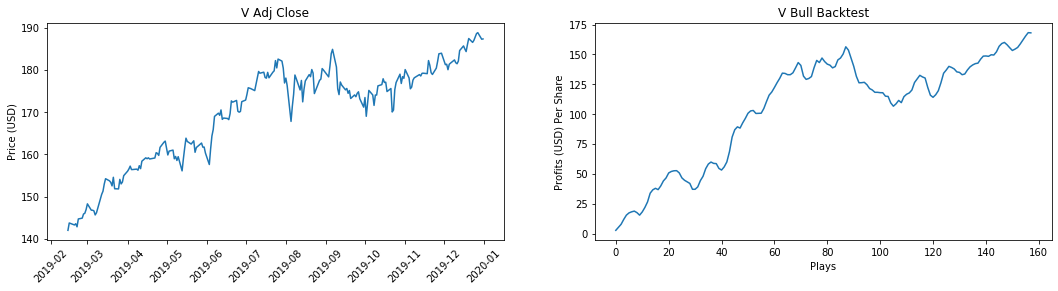

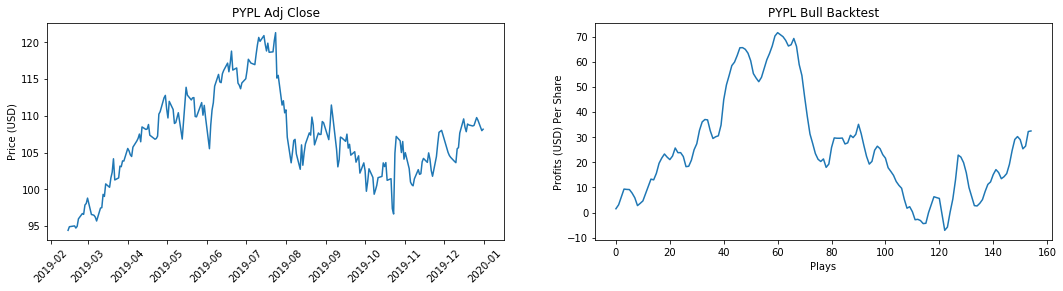

In [9]:
tickers = ['AMZN','MA','V','PYPL']
for ticker in tickers:
    backtest_df = create_backtest_df(ticker)
    run_backtest(backtest_df, ticker)